In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import pandas as pd
from sklearn.metrics import roc_curve

# 1D EM Case

In [20]:
# 1. Initialize parameters

K = 3
N = 1000

mu = np.array([1,2,3])
sigma = np.array([0.1, 0.3, 0.2])

norm0 = np.random.normal(mu[0], sigma[0], N)
norm1 = np.random.normal(mu[1], sigma[1], N)
norm2 = np.random.normal(mu[2], sigma[2], N)
data = np.concatenate((norm0, norm1, norm2))

In [45]:
# 2. E-step

def eStep(mu, sigma, pi): # based off of eq. 9.23
    gamma = np.zeros((N*K, K))
    for k in range(K):
        gamma[:, k] = pi[k] * norm.pdf(data, mu[k], sigma[k])
    gamma = gamma / np.sum(gamma, axis=1)[:, None]
    return gamma

In [26]:
# 3. M-step

def mStep(gamma): # based off of eq. 9.24-9.27
    Nk = np.sum(gamma, axis=0)
    mu = np.sum(gamma * data[:, None], axis=0) / Nk
    sigma = np.sqrt(np.sum(gamma * (data[:, None] - mu) ** 2, axis=0) / Nk)
    pi = Nk / N
    return mu, sigma, pi

In [35]:
# Plot Historgrams

def plotHist(data, mu, sigma, pi, iters, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.hist(data, bins=100, density=True)
    x = np.linspace(data.min(), data.max(), 1000)
    for k in range(K):
        ax.plot(x, pi[k] * norm.pdf(x, mu[k], sigma[k]), label=f'µ = {np.round(mu[k],3)}, ∑ = {np.round(np.sqrt(sigma[k]),3)}')
    ax.legend()
    ax.set_title(f'Histogram of data and fitted Gaussian distributions (Iteration: {iters})')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')

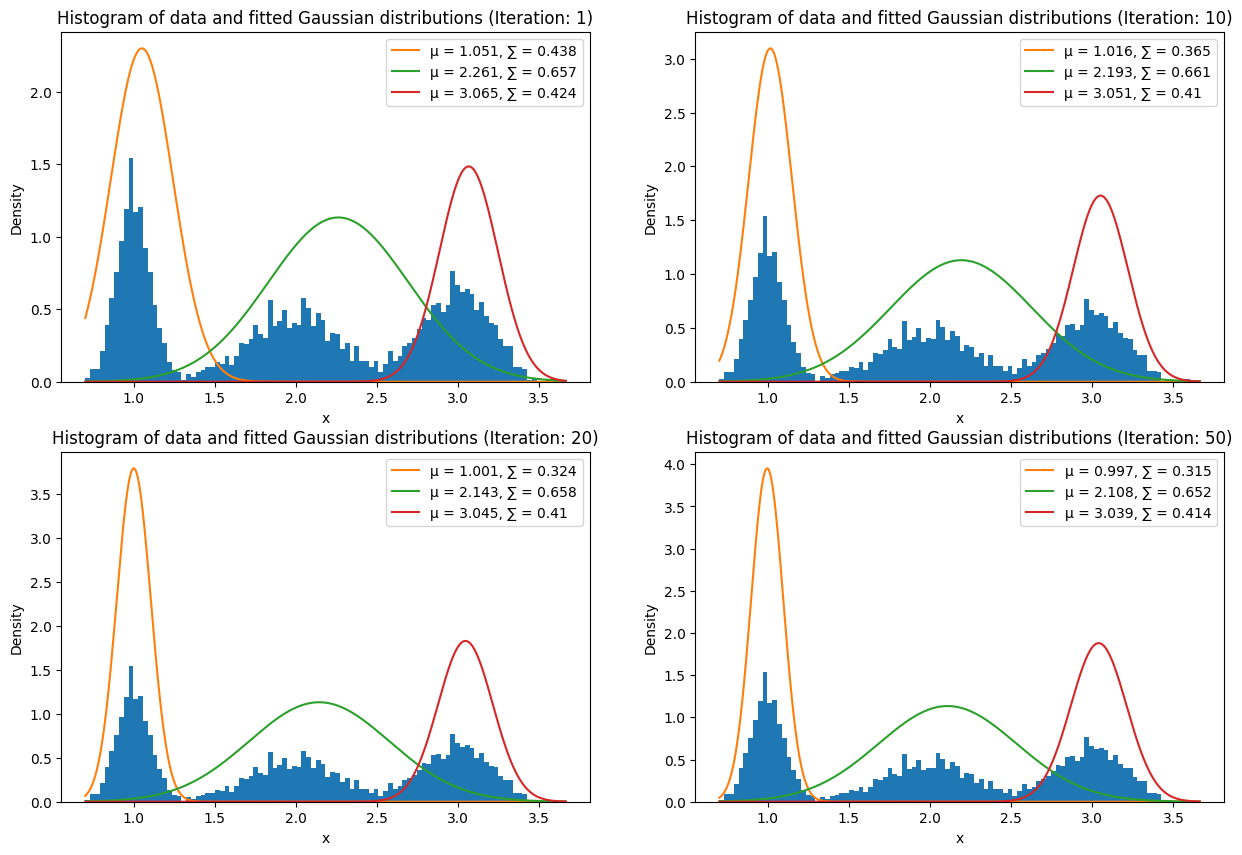

In [38]:
guess_mu = np.array([1.2, 2.3, 3.4])
guess_sigma = np.array([0.2, 0.4, 0.35])
guess_pi = np.array([1/3, 1/3, 1/3])

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
axs = ax.flatten()

for idx, iter in enumerate([1,10,20,50]):
    gamma = eStep(guess_mu, guess_sigma, guess_pi)
    guess_mu, guess_sigma, guess_pi = mStep(gamma)
    plotHist(data, guess_mu, guess_sigma, guess_pi, iter, ax=axs[idx])

plt.show()

# 2D EM Case

In [180]:
K = 2

faithful = pd.read_csv('faithful.csv')
data = faithful.to_numpy()
data[:, 1] = data[:, 1]/25          # scale the eruption time

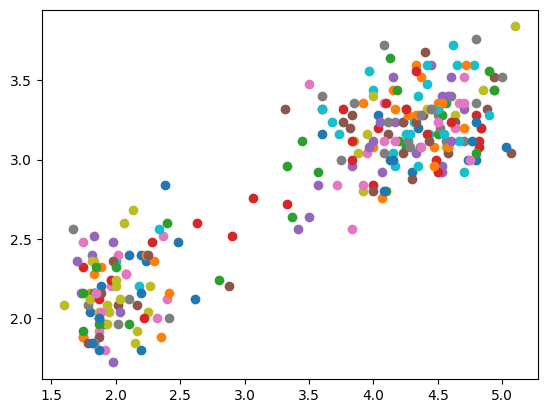

In [181]:
fig, ax = plt.subplots()
for d in range(len(data)):
    ax.scatter(data[d,0], data[d,1])    # Confetti! :D

In [245]:
def EM_2D(data, mu, cov, pi): # combining E and M steps
    # E-step
    n1 = pi[0] * multivariate_normal.pdf(data, mu[0], cov[0])
    n2 = pi[1] * multivariate_normal.pdf(data, mu[1], cov[1])
    denom = n1 + n2
    
    gamma1 = np.expand_dims(n1 / denom, axis=0)
    gamma2 = np.expand_dims(n2 / denom, axis=0)
    
    # M-step
    mu1 = np.sum(data * gamma1.T, axis=0) / np.sum(gamma1, axis=1)
    mu2 = np.sum(data * gamma2.T, axis=0) / np.sum(gamma2, axis=1)
    
    cov1 = np.absolute((gamma1 * (data - mu[0]).T @ (data - mu[0])) / np.sum(gamma1, axis=1))
    cov2 = np.absolute((gamma2 * (data - mu[1]).T @ (data - mu[1])) / np.sum(gamma2, axis=1))

    mu = np.stack((mu1, mu2))
    cov = np.stack((cov1, cov2))
    pi = np.zeros(K)
    pi[0] = np.sum(gamma1) / len(data)
    pi[1] = np.sum(gamma2) / len(data)
    

    gamma = np.concatenate((gamma1.T, gamma2.T), axis=1)

    return mu, cov, pi, gamma

In [249]:
def plotContours(data, mu, cov, pi, gamma, iters=0, ax=None):
    if ax is None:
        ax = plt.gca()
    if iters == 0:
        ax.scatter(data[:,0], data[:,1], color='black')
    else:
        for i in range(0, len(data)):
            alpha = np.argmax(gamma[i, :])
            if alpha == 0:
                ax.scatter(data[i,0], data[i,1], c='b', alpha=0.2)
            if alpha == 1:
                ax.scatter(data[i,0], data[i,1], c='r', alpha=0.2)

    x, y = np.mgrid[1:5.5:.01, 1.5:4:.01]
    pos = np.dstack((x, y))
    rv1 = multivariate_normal(mu[0], cov[0])
    rv2 = multivariate_normal(mu[1], cov[1])
    ax.contour(x, y, rv1.pdf(pos), colors='b', levels=0, zorder=4, linewidths = 2)
    ax.contour(x, y, rv2.pdf(pos), colors='r', levels=0, zorder=4, linewidths = 2)
    ax.set_title(f'Data points and fitted Gaussian distributions (Iters: {iters})')
    ax.set_xlabel('Waiting Time (Minutes)')
    ax.set_ylabel('Scaled Eruption Time (Minutes)')


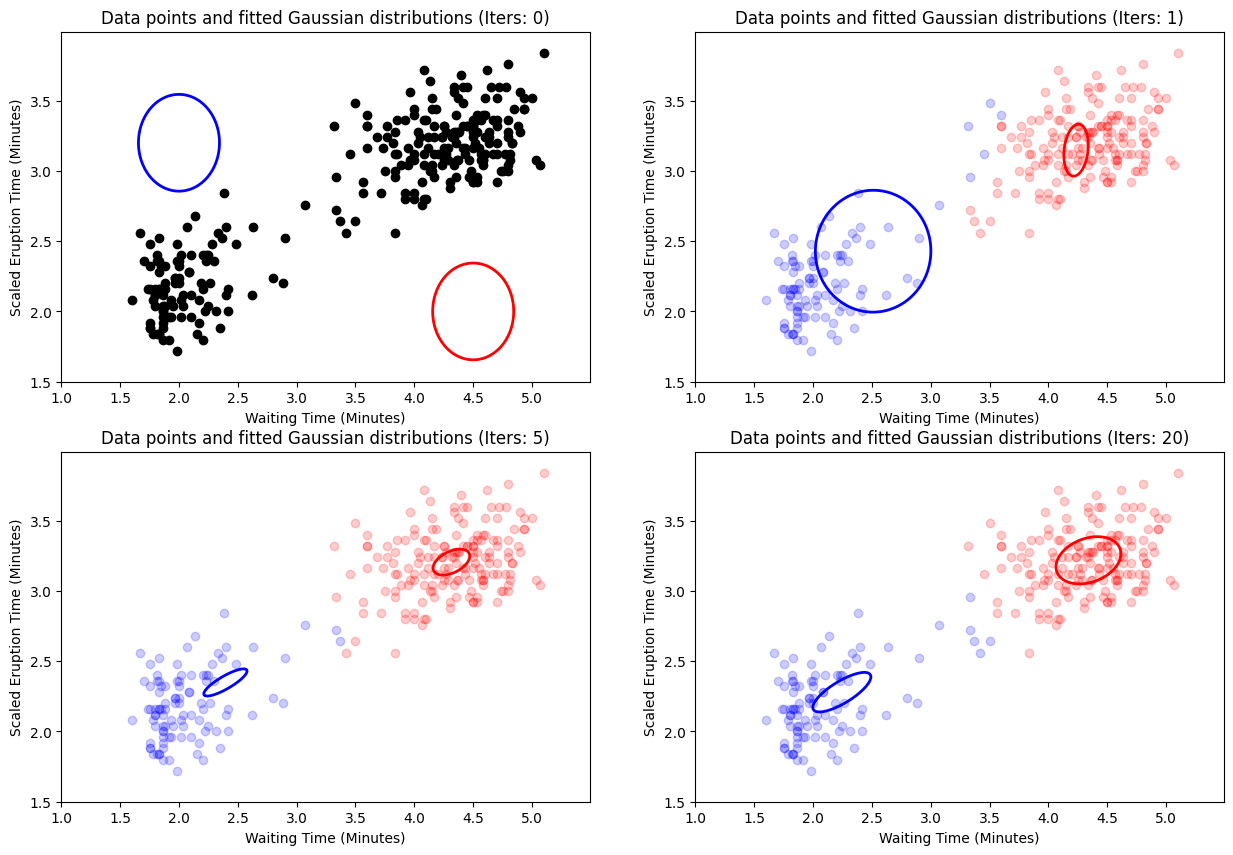

In [250]:
guess_mu = np.array([[2,3.2], [4.5,2]])
guess_cov = np.array([[[1,0], [0,1]], [[1,0], [0,1]]])
guess_pi = np.array([1/2, 1/2])

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
axs = ax.flatten()

plotContours(data, guess_mu, guess_cov, guess_pi, np.zeros((len(data), K)), ax=axs[0])

for idx, iter in enumerate([1,5,20]):
    guess_mu, guess_cov, guess_pi, gamma = EM_2D(data, guess_mu, guess_cov, guess_pi)
    plotContours(data, guess_mu, guess_cov, guess_pi, gamma, iter, ax=axs[idx+1])
